In [1]:
# in case there are any problems with importing because path is wrong
import sys
sys.path.append('C:/Users/nerpa\Dropbox (Personal)\Research\discrete_sr\code\python\SPIDER_discrete')

In [2]:
import numpy as np

from commons.weight import *
from utils import save, load
from library import *
from process_library_terms import *

In [3]:
%%prun # profiling

### load data
# vicsek:
#arrays.npy - normal. arrays2.npy - very few particles. arrays3.npy - high density. arrays4.npy - high density, low noise.
#arrays5.npy - small domain, one clump
#datasets = ['arrays.npy', 'arrays2.npy', 'arrays3.npy']#, 'arrays5.npy']
#datasets = ['data_bu.npy'] # burgers' equation data
## it may be interesting to reintroduce regression on multiple datasets,
## but for now we're just not going to do it

dataset = 'data_bu.npy'
#dataset = 'data_cbu.npy'
#dataset = 'lamp2.npy'
#dataset = 'lamp2_1e-4.npy'
#dataset = 'lamp_16x.npy'
#dataset = 'lamp_16x_half.npy'
#dataset = 'dump_16h1e4.npy'
#dataset = 'dump_16h1e4g.npy'
#dataset = 'dump_10wide.npy'
#dataset = 'dump_g.npy'
#dataset = 'dump_p.npy'
#dataset = 'dump_p_low.npy'
#dataset = 'dump_pshort.npy'
#dataset = 'dump_p_hf.npy'
#dataset = 'dump_p_uhf10.npy'
#dataset = 'billiard_states.npy'
#psvs = np.load('billiard_states.npy')
#positions = psvs[:, :2, :]
#vs = psvs[:, 2:, :]
#dims = [1, positions.shape[-1]]
#deltat = 0.002
#dataset = 'sim_n1024_1i1.0_2i1.0.npy'
#dataset = 'sim_n1024_1i10^-2.0_2i10^1.0.npy'
#dataset = 'sim_n1024_1i10^2.0_2i10^-1.0.npy'
#dataset = 'sim_n1024_1i10^0.5_2i10^-0.5.npy'
#dataset = 'sim_n1024_1i10^0.5_2i10^0.0.npy'
#dataset = 'cuda.npy'
#import scipy.io
#dataset = 'gas_1000_4_0.mat'
#dataset = 'gas_1000_16_4.mat'
#dataset = 'gas_5000_24_4.mat'
#matdata = scipy.io.loadmat(dataset)
#positions = matdata['pos_data']
#vs = matdata['vs_data']
#deltat = matdata['dt'][0][0]
#dims = matdata['dims'][0]
#for i, dset in enumerate(datasets):
positions, vs, deltat, dims = load(dataset, 4)
#pvdd = load(dataset, 1)
#positions = pvdd[0][:, :2, :]
#vs = pvdd[0][:, 2:, :]
#deltat = 0.00030517578125
#dims = [1, vs.shape[-1]]
#np_to_use = 100
#positions = positions[0:np_to_use, :, :]
#vs = vs[0:np_to_use, :, :]
deltat = float(deltat)
#deltat = float(deltat*8) # deltat value wrong because of subsampling
world_size = np.array([dims[0], dims[0], dims[1]])
#world_size = np.array([dims[0], dims[1], dims[2]])
print(world_size)
cg_res = 5#200/256 - lamp; 128 - Carlos; 20 - Jason; 5 - burgers
#world_size[2] += 1 # start at frame 2
#print(positions.shape)
#positions = positions[:, :, 1:]
#vs = vs[:, :, 1:]
#nt = dims[-1]
#positions = positions[:, :, :int(0.4*nt)]
#vs = vs[:, :, :int(0.4*nt)]
#world_size[2] = int(0.4*nt)
#world_size[2] = 50 # restrict to first 50 time steps
data_dict = {}
data_dict['v'] = vs # because scaling can be wrong when outputting directly from LAMMPS
v_obs = Observable('v', 1)
observables = [v_obs]

# fix random seed
np.random.seed(1)

# initial setup of dataset
srd = SRDataset(world_size, data_dict, positions, observables, 
                kernel_sigma=0.6, cg_res=cg_res, deltat=deltat, cutoff=6)
#kernel_sigma=0.01/0.04 (lamp),0.1 (Jason?),0.6 (burgers?)

# initialize libraries, domains, and weights
#srd.make_libraries(max_complexity=4, max_observables=3)
srd.make_libraries(max_complexity=5, max_observables=3, max_rho=2)
#srd.make_libraries(max_complexity=6, max_observables=4)

dom_width = 10#0.2 - LJ (lamp)/Carlos; 1.5 - Jason; 10 - Burgers?; 80 - ?
dom_time = 30 #20 - LJ/Carlos; 30/50 - Burgers
#srd.make_domains(ndomains=20, domain_size=[dom_width, dom_width, dom_time], pad=12)
srd.make_domains(ndomains=30, domain_size=[dom_width, dom_width, dom_time], pad=12)
#srd.make_domains(ndomains=500, domain_size=[dom_width, dom_width, dom_time], pad=12)
srd.make_weights(m=16, qmax=1) #qmax=1
srd.make_library_matrices(debug=False)

save('Q_bu.npy', srd.dxs, srd.libs)

[ 80.  80. 250.]
 

         18966244 function calls (17103860 primitive calls) in 93.184 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      300   21.383    0.071   27.282    0.091 process_library_terms.py:200(eval_cgp)
        1   12.287   12.287   93.158   93.158 process_library_terms.py:266(make_library_matrices)
   101520   11.156    0.000   11.389    0.000 polynomial.py:664(polyval)
    56880    7.532    0.000    8.407    0.000 function_base.py:4129(trapz)
    12960    6.462    0.000    6.481    0.001 diff.py:478(_apply_to_array)
917296/438981    5.558    0.000   24.128    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
    33600    3.936    0.000   70.660    0.002 process_library_terms.py:166(eval_term)
   101520    2.567    0.000    6.557    0.000 function_base.py:23(linspace)
   302100    2.185    0.000    2.185    0.000 {method 'reduce' of 'numpy.ufunc' objects}
    33840    1.498    0.000   29.235    

In [4]:
_, libs = load('Q_bu.npy', 2)
libs = libs.item()

In [11]:
import scipy.io
scipy.io.savemat('lammps_Qs.mat', {'Q0': libs[0].Q, 'Q1': libs[1].Q, 'n0': libs[0].col_weights,
                 'n1': libs[1].col_weights})

In [7]:
from identify_models import *
opts = dict()
# manually discourage polynomials
reweight = False
if reweight:
    for i, term in enumerate(libs[0].terms):
        if 'd' in str(term):
            libs[0].col_weights[i] *= 10
        libs[0].col_weights[i] *= 10**(str(term).count('rho')-1)
    for i, term in enumerate(libs[1].terms):
        libs[1].col_weights[i] *= 10**(str(term).count('rho')-1)
        if 'd' in str(term):
            libs[1].col_weights[i] *= 10
norm1 = False
#opts['threshold'] = "AIC"
opts['threshold'] = "threshold"
#opts['row_norms'] = libs[0].row_weights
#opts['method'] = "stepwise"
opts['method'] = "power"
opts['gamma'] = 2
opts['delta'] = 1e-8#1e-8 # apparently this reaches machine precision as the relative error
opts['anchor_norm'] = np.linalg.norm(libs[0].Q[:, 0])
# note - in the case of higher harmonics we do not have residual = 1 for 1 = 0 as expected.
opts['verbose'] = False
opts['char_sizes'] = libs[0].col_weights#np.linalg.norm(libs[0].Q, axis=0)
opts1 = opts.copy()
opts1['char_sizes'] = libs[1].col_weights#np.linalg.norm(libs[1].Q, axis=0)
if norm1:
    opts['char_sizes'] = np.linalg.norm(libs[0].Q, axis=0)
    opts1['char_sizes'] = np.linalg.norm(libs[1].Q, axis=0)
#opts1['row_norms'] = libs[1].row_weights

#Q = libs[0].Q
#print(Q[:, 3]+Q[:, 14], np.linalg.norm(Q[:, 3]+Q[:, 14]), 
#np.linalg.norm(Q[:, 3]+Q[:, 14])/np.linalg.norm(Q[:, 0]))
#print(np.linalg.norm(Q[:, 0])/libs[0].col_weights[0])
#print(list(zip(libs[1].terms, libs[1].col_weights)))
#eqs0, lambdas0, derived_eqs0, excluded_terms = identify_equations(Q0, opts, terms0, observables, threshold=1e-5, 
#                       max_complexity=None, max_equations=999, timed=True)
#print(excluded_terms)
#eqs1, lambdas1, derived_eqs1, excluded_terms = identify_equations(Q1, opts1, terms1, observables, threshold=1e-5, 
#                       max_complexity=None, max_equations=999, timed=True, excluded_terms=excluded_terms)
#print(excluded_terms)
eqs, lambdas, derived_eqs, excluded_terms = interleave_identify([libs[0].Q, libs[1].Q], 
[opts, opts1], [libs[0].terms, libs[1].terms], threshold=1e-3) #1e-3 #1e-2
#excluded_terms=set([libs[0].terms[10], libs[0].terms[16], libs[1].terms[25]]))
# eliminate simple rho^2-type terms immediately

[0.00 s]
Identified model: 1.0 * dj rho[v_j] + 0.9999999999972965 * dt rho = 0 (order 3, residual 3.41e-13)
[0.01 s]
Identified model: 1.0 * dj rho[v_i * v_j] + 0.9999999999981396 * dt rho[v_i] = 0 (order 4, residual 3.23e-13)
[0.01 s]
Identified model: 1.0 * dj rho[v_j * v_k * v_k] + 0.9999999999963769 * dt rho[v_j * v_j] = 0 (order 5, residual 6.69e-13)


<AxesSubplot:>

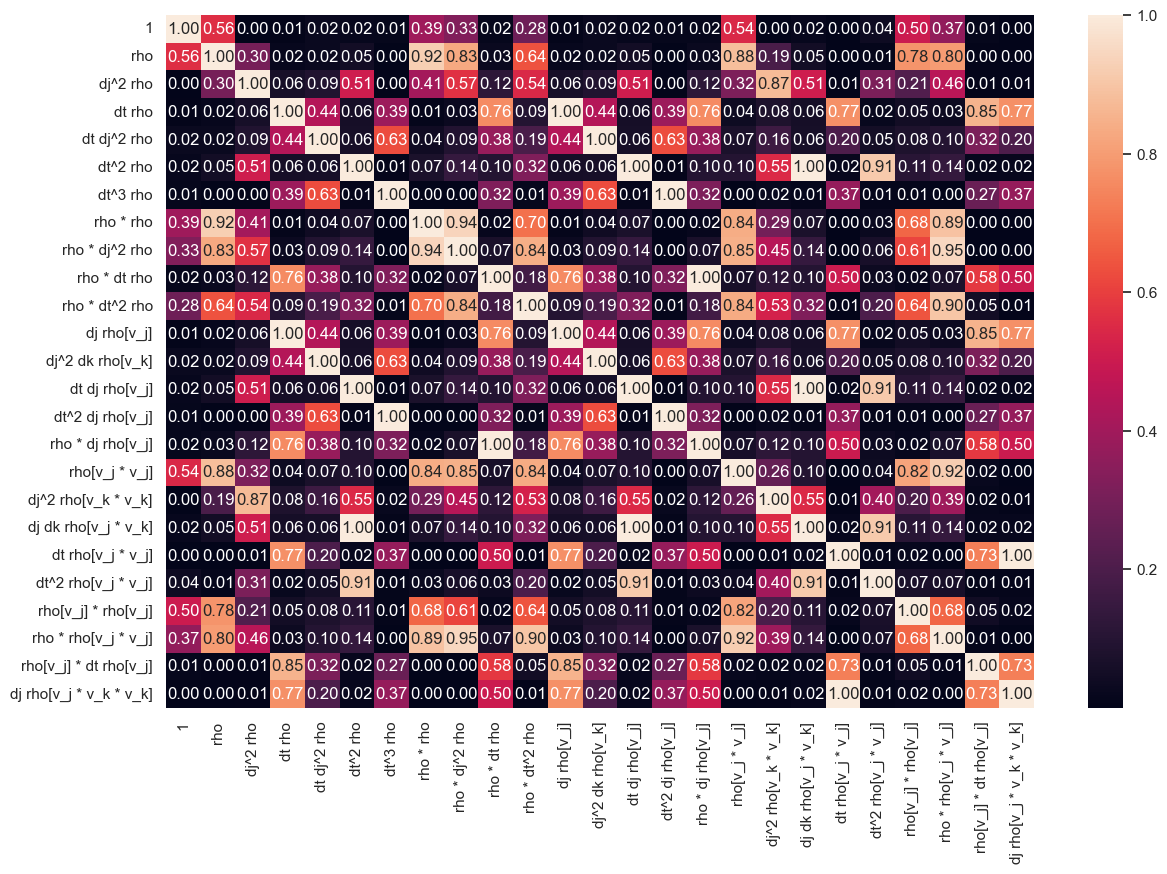

In [29]:
import seaborn as sns
%matplotlib inline
sns.set(rc={'figure.figsize':(14,9)})

# calculate the correlation matrix
R2 = (np.corrcoef(libs[0].Q, rowvar=False)**2)
# plot the heatmap
label_names = [str(term) for term in libs[0].terms]
sns.heatmap(R2, xticklabels=label_names, yticklabels=label_names, annot=True, fmt=".2f")

In [ ]:
import matplotlib.pyplot as plt
from utils import construct_from_string as cfs
fig, ax = plt.subplots(figsize=(6,6))
domain = srd.domains[0]
obs_dict = {'v': v_obs}
obs_dims = [0, 0, 0]
cgp = srd.cgps[-1]
data = srd.cg_dict[cgp, tuple(obs_dims), domain]
ax.imshow(data[:, :, 0])
print(np.mean(data))
print(np.mean(np.abs(data)))
print(np.std(data))

708.5852318400704
226.565913131023
0.6698766856813627


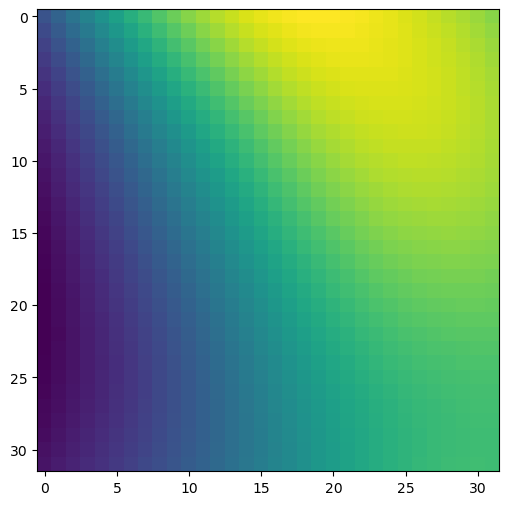

In [32]:
fig, ax = plt.subplots(figsize=(6,6))
domain = srd.domains[0]
obs_dict = {'v': v_obs}
obs_dims = [0]
cgp = srd.cgps[1]
data = srd.cg_dict[cgp, tuple(obs_dims), domain]
ax.imshow(data[:, :, 0])
print(np.mean(np.abs(data)))
print(np.std(data))
print(np.std(vs[np.abs(vs)<10]))

931.5940347304988
122.45974378385779


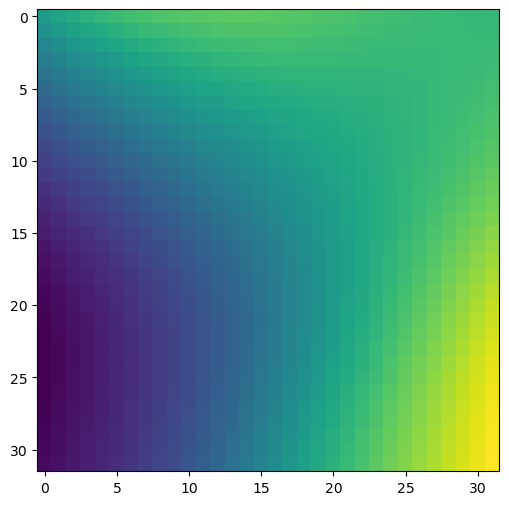

In [33]:
fig, ax = plt.subplots(figsize=(6,6))
domain = srd.domains[0]
obs_dict = {'v': v_obs}
obs_dims = []
cgp = srd.cgps[0]
data = srd.cg_dict[cgp, tuple(obs_dims), domain]
ax.imshow(data[:, :, 0])
print(np.mean(np.abs(data)))
print(np.std(data))

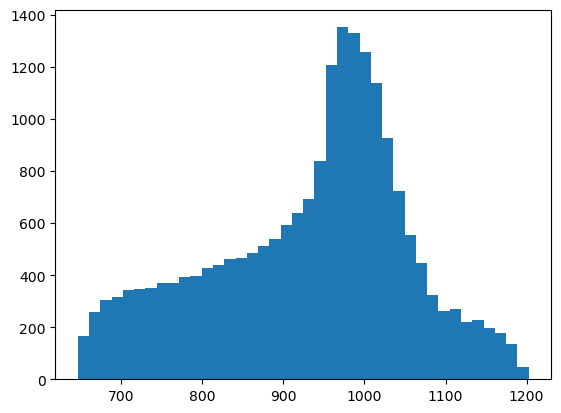

IntegrationDomain([37, 12, 72], [68, 43, 91])


In [10]:
plt.hist(data.flatten(), bins=40)
plt.show()
print(domain)

In [8]:
prts = []
for i in srd.domain_neighbors[domain, domain.times[0]]:
    prts.append(i)
print(np.std(vs[prts, :, domain.times[0]]))

0.20012994338106274


In [1]:
#data = []
#for domain in srd.domains[0]
#obs_dict = {'v': v_obs}
#obs_dims = []
#cgp = srd.cgps[0]
#data = srd.cg_dict[cgp, tuple(obs_dims), domain]
#ax.imshow(data[:, :, 0])

SyntaxError: invalid syntax (2885799474.py, line 2)

In [11]:
print(np.mean(positions[:, 0, :]))

0.2657824533912849


In [9]:
print(np.std(vs))

0.34736777173708616


In [6]:
## mostly not planning to use this code

from ipynb.fs.full.sparse_reg import *
opts = dict()
opts['threshold'] = "'pareto'"
#opts['verbose'] = True
#opts['brute_force'] = False
#opts['threshold'] = "'threshold'"
#opts['n_terms'] = len(terms0)
#opts['gamma'] = 1.2
opts['char_sizes'] = srd.libs[0].col_weights
Xi, lambd, best_term, lambda1 = sparse_reg(srd.libs[0].Q, opts=opts)
print(srd.libs[0].Q.shape)

(240, 28)


In [8]:
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {srd.libs[0].terms[i]}")
print("Model residual:", lambd)
print("One-term model residual:", lambda1)
print(f"Best term (#{best_term}):", srd.libs[0].terms[best_term])

[Term 19] 1.0 * rho[v_j] * rho[v_j]
Model residual: 0.0030944418121483697
One-term model residual: 1.294046607514735e-05
Best term (#6): dt^3 rho


In [ ]:
opts['verbose'] = True
opts['char_sizes'] = srd.libs[1].col_weights
opts['avoid'] = []
opts['row_norms'] = None
Xi, lambd, best_term, lambda1 = sparse_reg(srd.libs[1].Q, opts=opts)
print(srd.libs[1].Q.shape)

In [ ]:
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {srd.libs[1].terms[i]}")
print("Model residual:", lambd)
print("One-term model residual:", lambda1)
print("Best term:", srd.libs[1].terms[best_term])

In [17]:
for i, term, size in zip(list(range(len(libs[0].terms))), libs[0].terms, libs[0].col_weights):
    print(i, term, size)
for i, term, size in zip(list(range(len(libs[1].terms))), libs[1].terms, libs[1].col_weights):
    print(i, term, size)

0 1 1
1 rho 2500.00026086402
2 dj^2 rho 1405.9552263638793
3 dt rho 1405.9552263638793
4 dt dj^2 rho 1405.9552263638793
5 dt^2 rho 1405.9552263638793
6 dt^3 rho 1405.9552263638793
7 rho * rho 6250001.30432017
8 rho * dj^2 rho 3514888.4326728308
9 rho * dt rho 3514888.4326728308
10 rho * dt^2 rho 3514888.4326728308
11 dj rho[v_j] 6.287057016822064
12 dj^2 dk rho[v_k] 6.287057016822064
13 dt dj rho[v_j] 6.287057016822064
14 dt^2 dj rho[v_j] 6.287057016822064
15 rho * dj rho[v_j] 15717.644182122127
16 rho[v_j * v_j] 0.04999100536599431
17 dj^2 rho[v_k * v_k] 0.028114043172624777
18 dj dk rho[v_j * v_k] 0.028114043172624777
19 dt rho[v_j * v_j] 0.028114043172624777
20 dt^2 rho[v_j * v_j] 0.028114043172624777
21 rho[v_j] * rho[v_j] 124.97752645584042
22 rho * rho[v_j * v_j] 124.97752645584042
23 rho[v_j] * dt rho[v_j] 70.28511526550437
24 dj rho[v_j * v_k * v_k] 0.00012571850730753122
0 di rho 1405.9552263638793
1 di dj^2 rho 1405.9552263638793
2 dt di rho 1405.9552263638793
3 dt^2 di rho 1

In [16]:
for i in [3, 14, 13, 26, 31, 33, 68, 18, 29]:
    print(libs[1].terms[i-1])

dt di rho
di dj rho[v_j]
rho[v_i]
rho * rho[v_i]
rho * rho * rho[v_i]
rho * rho * rho * rho[v_i]
rho[v_j] * dt rho[v_i * v_j]
dt rho[v_i]
rho * dt rho[v_i]


In [6]:
continuity_terms = ['dt rho', 'dj rho[v_j]']
#continuity_terms = ['1', 'rho', 'rho * rho']
#continuity_terms = ['rho * rho[v_j * v_j]', 'rho[v_j] * rho[v_j]', 'rho']
#continuity_terms = ['rho * dt rho', 'rho * dj rho[v_j]']
#continuity_terms = ['dt rho * rho', 'rho * rho * dj v_j', 'dj rho * rho * v_j']
#continuity_terms = ['dt rho', 'dj rv_j']
col_numbers = [find_term(libs[0].terms, name) for name in continuity_terms]
Xi, lambd = regress(libs[0].Q, col_numbers)
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {libs[0].terms[i]}. (Char. size: {libs[0].col_weights[i]})")
print("Model residual:", lambd)

[Term 3] 0.9926640242191918 * dt rho. (Char. size: 127.38429347903242)
[Term 11] 1.0 * dj rho[v_j]. (Char. size: 37.15183572830772)
Model residual: 35388.06041833102


In [7]:
from scipy.stats.stats import pearsonr 
print(np.vstack([libs[0].Q[1:10, 3],libs[1].Q[1:10, 11]]))
print(0.976*libs[0].Q[1:10, 3]+libs[0].Q[1:10, 11])
print(pearsonr(libs[0].Q[:, 3], libs[0].Q[:, 11]))
print(np.mean(np.abs(libs[0].Q[:, 3])/np.mean(np.abs(libs[0].Q[:, 11]))))

[[-1.918e+05 -1.163e+05 -1.088e+05 -1.001e+05 -1.210e+05 -2.150e+05
   3.988e+04  4.641e+05 -2.629e+05]
 [-3.278e+08  2.196e+08 -1.841e+07  1.991e+08 -8.285e+07  5.604e+07
   1.628e+08  5.797e+08  2.666e+07]]
[ 2473.211  3613.582 -4643.103 -3923.648  8787.794 -9578.998  9241.658
 -6845.099  8665.075]
(-0.9994009354647413, 0.0)
1.00808941657034


In [8]:
print(np.vstack([libs[1].Q[1:10, 9],libs[1].Q[1:10, 17]]))
print(0.51*libs[1].Q[1:10, 9]+libs[1].Q[1:10, 17])
print(pearsonr(libs[1].Q[:, 9], libs[1].Q[:, 17]))
print(np.mean(np.abs(libs[1].Q[:, 9])/np.mean(np.abs(libs[1].Q[:, 17]))))

[[ 426399.432 -117629.328 -347477.276 -185959.026   -1335.408   19657.542
  -129532.865 -477933.521  -17532.697]
 [ -53971.023  -25467.455   23123.166   81551.39   -30894.691   96931.228
    39849.469   29409.035    6965.606]]
[ 163492.687  -85458.413 -154090.245  -13287.714  -31575.749  106956.574
  -26212.292 -214337.061   -1976.07 ]
(-0.6997746610668591, 7.754448403691412e-72)
2.761917413140266


In [9]:
print(np.linalg.norm(libs[0].Q[:, :], axis=0)/libs[0].col_weights)

[9.288e+02 9.233e+02 6.275e+05 8.058e+03 1.212e+07 3.282e+05 3.891e+07
 9.470e+02 5.922e+05 7.841e+03 3.189e+05 2.743e+04 4.160e+07 1.143e+06
 1.324e+08 2.666e+04 1.812e+03 2.252e+06 1.656e+06 8.179e+04 5.880e+06
 1.246e+02 1.822e+03 6.344e+03 1.289e+05]


In [1]:
#burger_terms = ['dt rho[v_i]', 'dj rho[v_i * v_j]']
#burger_terms = ['dt rho[v_i]', 'dj rho[v_i * v_j]', 'di rho[v_j * v_j]']#, 'dj^2 rho[v_i]']# 'dj^2 rho[v_i]']
burger_terms = ['rho * rho[v_i]', 'rho[v_i]']
#burger_terms = ['rho[v_i]', 'rho[v_i * v_j * v_j]']
#burger_terms = ['rho * dt rv_i', 'dj rv_i * rv_j']
col_numbers = [find_term(libs[1].terms, name) for name in burger_terms]
Xi, lambd = regress(libs[1].Q, col_numbers)
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {libs[1].terms[i]}. (Char. size: {libs[1].col_weights[i]})")
print("Model residual:", lambd)

NameError: name 'find_term' is not defined

In [14]:
### not fixed (obviously)
#veqconst_terms = ['1', 'v_j * v_j']
veqconst_terms = ['rho', 'rho * v_j * v_j']
col_numbers = [find_term(terms0, name) for name in veqconst_terms]
Xi, lambd = regress(Q0, col_numbers)
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {terms0[i]}. (Char. size: {char_sizes0[i]})")
print("Model residual:", lambd)

[Term 16] -0.004286563115825593 * rho. (Char. size: 0.1464261231728444)
[Term 28] 1.0 * rho * v_j * v_j. (Char. size: 0.0005121399208783936)
Model residual: 0.0005697337514007149


In [ ]:
rho dt^2 v = 10^-4 dt rho * grad rho

In [144]:
### (1, 1) - col size norm, long trajectory, larger domains, sigma=0.04 ###
[0.01 s]
Identified model: 0.9999941767033532 * dj rho[v_j] + 1.0 * dt rho = 0 (order 3, residual 9.91e-08)
[0.12 s]
Identified model: 1.0 * dt rho + -0.0019393012307609143 * rho * dt rho + 9.351022221012353e-07 * rho * rho * dt rho = 0 (order 5, residual 2.63e-06)
[0.24 s]
Identified model: 1.0 * 1 + -0.0009916867285711317 * rho + 1.1697095194982046e-06 * rho * rho[v_j * v_j] + -0.00117931738281563 * rho[v_j * v_j] = 0 (order 5, residual 1.44e-05)
[0.36 s]
Identified model: 1.0 * dj^2 rho + -0.46760700423159485 * dt^2 rho + -0.0009632186103852298 * rho * dj^2 rho + 0.00045384794082332236 * rho * dt^2 rho = 0 (order 5, residual 2.70e-05)
[0.60 s]
Identified model: 1.0 * di rho + -0.0019257584194597244 * rho * di rho + 9.238594430200825e-07 * rho * rho * di rho = 0 (order 5, residual 2.27e-06)
[0.60 s]
Identified model: 1.0 * dt^2 rho + -0.001935212535739339 * rho * dt^2 rho + 9.290322822931163e-07 * rho * rho * dt^2 rho = 0 (order 6, residual 5.65e-06)
[1.18 s]
Identified model: 1.0 * 1 + -0.0012907457494940621 * rho + 2.855577751197353e-13 * rho * rho * rho * rho = 0 (order 6, residual 8.56e-06)
[1.70 s]
Identified model: 1.0 * dt dj^2 rho + -0.22515238860762746 * dt^3 rho + -0.0009599756835766671 * rho * dt dj^2 rho + 0.00021603618213135008 * rho * dt^3 rho = 0 (order 6, residual 2.04e-05)
[2.22 s]
Identified model: 1.0 * dt rho[v_j * v_j] + 0.0005155153703625918 * dt^3 rho + -0.0009685487841685498 * rho * dt rho[v_j * v_j] + -4.939861238044323e-07 * rho * dt^3 rho = 0 (order 6, residual 3.79e-05)
[2.67 s]
Identified model: 1.0 * dt rho + -0.32875738821901135 * dt rho[v_j * v_j] + -0.0009547248510533903 * rho * dt rho + 0.00031922445963196937 * rho * dt rho[v_j * v_j] = 0 (order 6, residual 3.05e-05)
[4.12 s]
Identified model: 1.0 * dt di rho + -0.0019356351920459833 * rho * dt di rho + 9.329988764183588e-07 * rho * rho * dt di rho = 0 (order 6, residual 1.79e-06)
[8.06 s]
Identified model: 1.0 * dt rho[v_i] + -0.0019280208944151233 * rho * dt rho[v_i] + 9.251916968812042e-07 * rho * rho * dt rho[v_i] = 0 (order 6, residual 2.79e-06)
[11.81 s]
Identified model: 1.8196598972472693e-09 * rho * rho * rho * rho[v_i] + -2.824835613618127e-06 * rho * rho * rho[v_i] + 1.0 * rho[v_i] = 0 (order 6, residual 4.71e-06)
[15.31 s]
Identified model: 1.0 * di rho + 0.37610159292712514 * dj rho[v_i * v_j] + 0.3933421416870819 * dt rho[v_i] + -0.0009813596765878676 * rho * di rho + -0.00036626024192678794 * rho * dj rho[v_i * v_j] + -0.0003857345839495145 * rho * dt rho[v_i] = 0 (order 6, residual 1.34e-05)
[18.70 s]
Identified model: 6.924968913187393e-07 * rho * rho * rho[v_i] + -0.0009744242046365395 * rho * rho[v_i * v_j * v_j] + 1.0 * rho[v_i * v_j * v_j] + -0.739382581026262 * rho[v_i] = 0 (order 6, residual 1.37e-05)
[21.98 s]
Identified model: 1.0 * di dj^2 rho + -0.3817391735900403 * dt^2 di rho + -0.000995404392102315 * rho * di dj^2 rho + 0.00037691444729516017 * rho * dt^2 di rho = 0 (order 6, residual 3.58e-05)

SyntaxError: invalid syntax (3756173767.py, line 1)

In [ ]:
### sigma = 0.01 ###
[0.02 s]
Identified model: 0.9999999959627874 * dj rho[v_j] + 1.0 * dt rho = 0 (order 3, residual 6.34e-12)
[1.35 s]
Identified model: 1.0 * di rho + -0.0018633277640221532 * rho * di rho + 7.002008258355073e-07 * rho * rho * di rho = 0 (order 5, residual 4.90e-05)
[2.58 s]
Identified model: -0.9666862875871163 * rho[v_i] * rho[v_j * v_j] + 1.0 * rho[v_j] * rho[v_i * v_j] = 0 (order 5, residual 7.85e-05)
[2.00 s]
Identified model: 3.9293130942914495e-07 * rho * rho * rho[v_j * v_j] + -0.0013749461512638003 * rho * rho[v_j * v_j] + 1.0 * rho[v_j * v_j] = 0 (order 6, residual 2.39e-05)
[3.89 s]
Identified model: -0.0006114367940185144 * rho * rho[v_j * v_j] + 4.417065809582353e-07 * rho * rho[v_j] * rho[v_j] + 1.0 * rho[v_j * v_j] + -0.0008597016181151673 * rho[v_j] * rho[v_j] = 0 (order 6, residual 4.10e-05)
[5.63 s]
Identified model: 1.0 * 1 + -2.756684842649201e-07 * dj^2 rho + 6.255878773278568e-10 * rho * dj^2 rho + -1.7314136727527456e-13 * rho * rho * dj^2 rho = 0 (order 6, residual 3.79e-05)
[7.41 s]
Identified model: -0.00012408079785366727 * dt^2 rho + 2.4118467865909007e-07 * rho * dt^2 rho + -8.85167280410579e-11 * rho * rho * dt^2 rho + -0.0007071048985563922 * rho * rho[v_j * v_j] + 1.0 * rho[v_j * v_j] = 0 (order 6, residual 3.46e-05)
[9.14 s]
Identified model: 4.1105500057476617e-10 * rho * rho * rho * rho[v_i] + -1.2071852387395117e-06 * rho * rho * rho[v_i] + 1.0 * rho[v_i] = 0 (order 6, residual 3.62e-05)
[17.92 s]
Identified model: 1.0 * rho[v_i * v_j * v_j] + 4.959952200079346e-07 * rho[v_i] * rho[v_j] * rho[v_j] + -0.0015942484232388517 * rho[v_j] * rho[v_i * v_j] = 0 (order 6, residual 6.14e-05)
[26.20 s]
Identified model: 0.6415296986083273 * dj rho[v_i * v_j] + 1.0 * dt rho[v_i] + -0.00048261110036053247 * rho * dj rho[v_i * v_j] + -0.0012608752996658289 * rho * dt rho[v_i] + 3.2533737106148037e-07 * rho * rho * dt rho[v_i] = 0 (order 6, residual 4.06e-05)

In [ ]:
### (3, 0.3)
0.998 * dj rho[v_i * v_j] + 1.0 * dt rho[v_i] + 1.10e-05 * di rho^2 = 0
### (3, 1)
Identified model: 0.993633815171316 * dt dj rho[v_i * v_j] + 1.0 * dt^2 rho[v_i] + -0.0004986445654309399 * rho * dt^2 rho[v_i] + -0.0005185104934969214 * rho[v_i] * dt dj rho[v_j] = 0 (order 6, residual 3.45e-05)